In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

## Load data sources

In [38]:
# load the list which assigns events to categories
filename_event_list = "../moodle_default_events_list.xlsx"
event_list = pd.read_excel(filename_event_list, header=7)
event_list = event_list.rename(columns = {"Extracted Event Name":"eventname", "Active/Passive":"activepassive", "User-Agent-Based":"useragentbased", "Novel Learning-Cycle":"newlc"})
event_list = event_list[["eventname", "activepassive", "useragentbased", "newlc"]]
event_list[:3]

,eventname,activepassive,useragentbased,newlc
0,\core\event\badge_archived,22 passive,4 Student-System,NaN
1,\core\event\badge_awarded,22 passive,6 Course Relevant Actions,NaN
2,\core\event\badge_created,NaN,5 Others,NaN


In [55]:
# convert columns to strings for the events
event_list_string_columns = ["eventname", "activepassive", "useragentbased", "newlc"]
for c in event_list_string_columns:
  event_list[c] = event_list[c].astype('string')

In [39]:
# load the moodle course log
filename_course_log = 'course_log.pkl'
course_log_list = pd.read_pickle(filename_course_log)
course_log = pd.DataFrame(course_log_list)
course_log[:3]

,action,target,crud,contextlevel,edulevel,eventname,userid,role,relateduserid,courseid,timecreated
0,viewed,course,r,50,2,\core\event\course_viewed,13,norole,NaN,3,1598956500
1,viewed,user_list,r,50,0,\core\event\user_list_viewed,13,norole,NaN,3,1598956507
2,viewed,user_list,r,50,0,\core\event\user_list_viewed,13,norole,NaN,3,1598956516


In [58]:
# convert columns to strings for the course log
course_log_string_columns = ["action", "target", "crud", "eventname", "role"]
for c in course_log_string_columns:
  course_log[c] = course_log[c].astype('string')

## Start data handling

In [59]:
# count the occurrence of each event type
event_frequency = course_log.groupby(["userid","eventname"]).count()
event_frequency = event_frequency.drop(labels=[c for c in event_frequency.columns[1:]], axis="columns")
event_frequency = event_frequency.rename(columns = {"action":"count"})
event_frequency = event_frequency.reset_index()
event_frequency

,userid,eventname,count
0,2,\core\event\capability_assigned,1
1,2,\core\event\course_restored,1
2,2,\core\event\course_section_created,3
3,2,\core\event\course_viewed,8
4,2,\core\event\enrol_instance_created,1
...,...,...,...
803,76,\mod_workshop\event\course_module_viewed,19
804,76,\mod_workshop\event\submission_assessed,7
805,76,\mod_workshop\event\submission_created,2
806,76,\mod_workshop\event\submission_updated,2


In [66]:
# somehow the type gets lost when grouping on it
event_frequency["eventname"] = event_frequency["eventname"].astype('string')

In [72]:
overview = event_frequency.join(event_list, rsuffix="_ef")
overview

,userid,eventname,count,eventname_ef,activepassive,useragentbased,newlc
0,2,\core\event\capability_assigned,1,\core\event\badge_archived,22 passive,4 Student-System,<NA>
1,2,\core\event\course_restored,1,\core\event\badge_awarded,22 passive,6 Course Relevant Actions,<NA>
2,2,\core\event\course_section_created,3,\core\event\badge_created,<NA>,5 Others,<NA>
3,2,\core\event\course_viewed,8,\core\event\badge_criteria_created,<NA>,5 Others,<NA>
4,2,\core\event\enrol_instance_created,1,\core\event\badge_criteria_deleted,<NA>,5 Others,<NA>
...,...,...,...,...,...,...,...
803,76,\mod_workshop\event\course_module_viewed,19,<NA>,<NA>,<NA>,<NA>
804,76,\mod_workshop\event\submission_assessed,7,<NA>,<NA>,<NA>,<NA>
805,76,\mod_workshop\event\submission_created,2,<NA>,<NA>,<NA>,<NA>
806,76,\mod_workshop\event\submission_updated,2,<NA>,<NA>,<NA>,<NA>


In [82]:
# map events with interaction categories
overview = pd.merge(event_frequency, event_list, how="left", on="eventname")
overview

,userid,eventname,count,activepassive,useragentbased,newlc
0,2,\core\event\capability_assigned,1,<NA>,5 Others,<NA>
1,2,\core\event\course_restored,1,<NA>,5 Others,<NA>
2,2,\core\event\course_section_created,3,<NA>,5 Others,<NA>
3,2,\core\event\course_viewed,8,22 passive,3 Student-Content,1 Engagement
4,2,\core\event\enrol_instance_created,1,<NA>,5 Others,<NA>
...,...,...,...,...,...,...
803,76,\mod_workshop\event\course_module_viewed,19,11 active,3 Student-Content,2 Content
804,76,\mod_workshop\event\submission_assessed,7,11 active,3 Student-Content,3 Application
805,76,\mod_workshop\event\submission_created,2,11 active,3 Student-Content,3 Application
806,76,\mod_workshop\event\submission_updated,2,11 active,3 Student-Content,3 Application


In [83]:
# only get rows with at least one
nan_mask = overview["newlc"].notnull()
overview_newlc = overview[nan_mask]
overview_newlc

,userid,eventname,count,activepassive,useragentbased,newlc
3,2,\core\event\course_viewed,8,22 passive,3 Student-Content,1 Engagement
11,2,\core\event\user_list_viewed,3,<NA>,5 Others,6 LPM
12,2,\mod_assign\event\course_module_viewed,2,22 passive,3 Student-Content,2 Content
13,2,\mod_assign\event\submission_status_viewed,2,22 passive,3 Student-Content,5 Track/review
14,2,\mod_resource\event\course_module_viewed,1,11 active,3 Student-Content,2 Content
...,...,...,...,...,...,...
803,76,\mod_workshop\event\course_module_viewed,19,11 active,3 Student-Content,2 Content
804,76,\mod_workshop\event\submission_assessed,7,11 active,3 Student-Content,3 Application
805,76,\mod_workshop\event\submission_created,2,11 active,3 Student-Content,3 Application
806,76,\mod_workshop\event\submission_updated,2,11 active,3 Student-Content,3 Application


### Radar Chart Meta Functions
From: https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

In [84]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [144]:


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

### Create Radar Chart

In [166]:
data_labels = ["Engagement", "Content", "Application", "Dialogue/sharing", "Track/review", "LPM"]
data = [
  [1,2,3,4,5,6],
  [6,5,4,3,2,1]
]
N = len(data[0])
theta = radar_factory(N, frame='polygon')
colors = ['b', 'r']

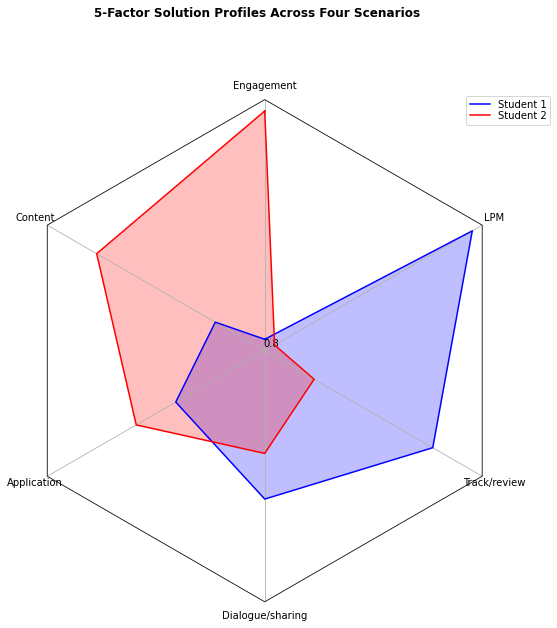

In [167]:
fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05) # required to position labels properly

# Plot the four cases from the example data on separate axes
ax.set_rgrids([0.2, 0.4, 0.6, 0.8])

for d, color in zip(data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
ax.set_varlabels(data_labels)

# add legend relative to top-left plot
labels = ('Student 1', 'Student 2')
legend = ax.legend(labels, loc=(0.9, .95), labelspacing=0.1)

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
          horizontalalignment='center', color='black', weight='bold',
          size='large')

plt.show()


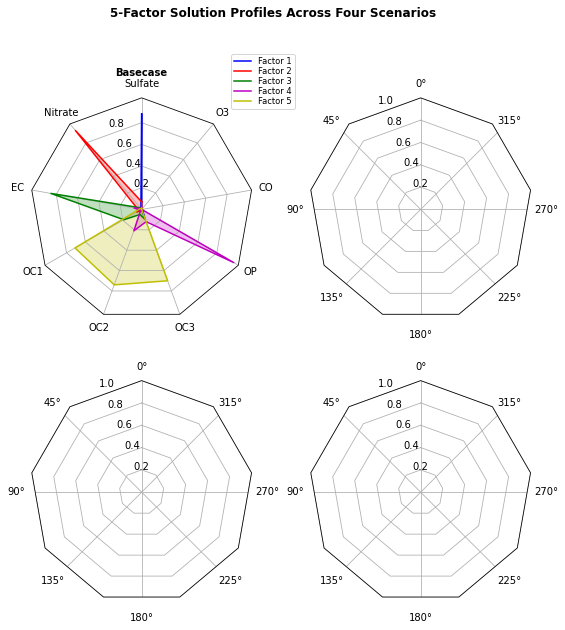

In [163]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)
        break

    # add legend relative to top-left plot
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

### Basic Analysis for old Categorization

<BarContainer object of 5 artists>

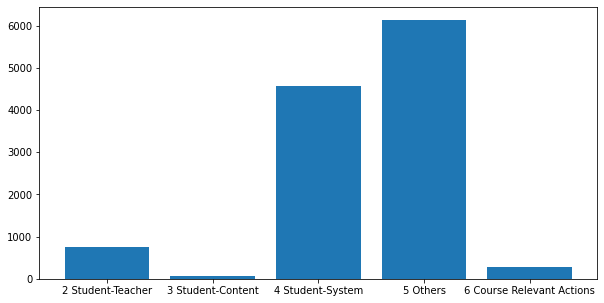

In [86]:
# TODO: delete since obsolete, keep just as reference for the moment 22.02.2022
# repeat counting (for compatibility)
event_frequency = course_log.groupby(["eventname"]).count()
overview = event_frequency.join(event_list, rsuffix="_ef").drop("eventname_ef", axis='columns')

user_agent_based = overview.groupby("useragentbased").sum()["count"]
plt.figure(figsize=(10,5))
plt.bar(user_agent_based.index, user_agent_based)

<BarContainer object of 2 artists>

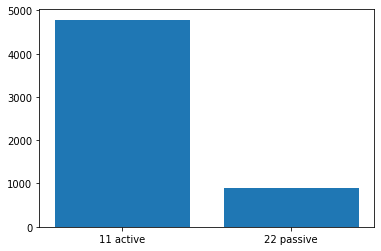

In [88]:
active_passive = overview.groupby("activepassive").sum()["count"]
plt.bar(active_passive.index, active_passive)